In [4]:
import os

from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset
from torchvision.transforms import Compose, Resize, Grayscale, ToTensor, Normalize, ToPILImage



class Manga109Dataset(Dataset):
    """
    A PyTorch Dataset for the Manga109 dataset.

    Attributes
    ----------
    root_dir : str
        The root directory of the dataset.
    transform : callable, optional
        An optional transform to be applied on the images.
    samples : list
        A list of tuples where each tuple contains an image path and its corresponding bounding box.
    """


    def __init__(self, root_dir, transform=None):
        """
        Parameters
        ----------
        root_dir : str
            The root directory of the dataset.
        transform : callable, optional
            An optional transform to be applied on the images.
        """
        self.root_dir = root_dir
        self.samples = self._load_samples()
        self.transform = transform

    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return len(self.samples)

    def __getitem__(self, idx):
        """
        Returns the image and its bounding box at the specified index.

        Parameters
        ----------
        idx : int
            The index of the sample to fetch.

        Returns
        -------
        image : PIL.Image
            The image at the specified index.
        bbox_tensor : torch.Tensor
            The bounding box of the image at the specified index.
        """
        image_path, bbox = self.samples[idx] # Get the image path and its bounding box
        image = Image.open(image_path) # Open the image using PIL
        bbox_tensor = torch.tensor(bbox, dtype=torch.float32) # Convert the bounding box to a tensor

        if self.transform: # Apply the transformation if it exists
            image = self.transform(image)

        return image, bbox_tensor

    def _load_samples(self):
        """
        Loads and returns all samples from the dataset.

        Returns
        -------
        samples : list
            A list of tuples where each tuple contains an image path and its corresponding bounding box.
        """
        samples = []
        annotations_dir = os.path.join(self.root_dir, 'annotations')
        images_dir = os.path.join(self.root_dir, 'images')

        for annotation_file in os.listdir(annotations_dir):
            tree = ET.parse(os.path.join(annotations_dir, annotation_file))
            root = tree.getroot()
            book_title = root.get('title')

            for page in root.find('pages'):
                page_index = page.get('index')
                # Adjust the format here to zero-pad the page index to three digits
                image_path = os.path.join(images_dir, book_title, f'{int(page_index):03}.jpg')

                for frame in page.findall('frame'):
                    bbox = (
                        int(frame.get('xmin')),
                        int(frame.get('ymin')),
                        int(frame.get('xmax')),
                        int(frame.get('ymax'))
                    )
                    samples.append((image_path, bbox))

        return samples

    def load_manga_page(self, manga_title, page_index, transformed=False):
        """
        Loads and returns a manga page along with its annotations.

        Parameters
        ----------
        manga_title : str
            The title of the manga.
        page_index : int
            The index of the page to load.
        transformed : bool, optional
            Whether to apply the transformation on the image.

        Returns
        -------
        image : PIL.Image
            The manga page image.
        elements : dict
            A dictionary containing the bounding boxes of the frames, texts, faces, and bodies.
            Each key is a string ('frame', 'text', 'face', 'body') and each value is a list of bounding boxes.
            Each bounding box is a dictionary with keys 'xmin', 'ymin', 'xmax', 'ymax' and values as the respective coordinates.

        Raises
        ------
        FileNotFoundError
            If the specified manga title or page index does not exist.

        Notes
        -----
        This method opens the image file, applies the transformation if `transformed` is True, and then scales the bounding box coordinates based on the new image size.
        It then parses the XML annotation file to extract the bounding boxes of the frames, texts, faces, and bodies.
        Finally, it displays the image and overlays the bounding boxes using matplotlib.
        """
        xml_path = os.path.join(self.root_dir, 'annotations', f'{manga_title}.xml')
        image_path = os.path.join(self.root_dir, 'images', manga_title, f'{page_index:03}.jpg')

        if not os.path.exists(xml_path) or not os.path.exists(image_path):
            raise FileNotFoundError("The specified manga title or page index does not exist.")

        image = Image.open(image_path)
        original_width, original_height = image.size

        if transformed:
            image = self.transform(image.copy())  # Apply the transformation
            image = ToPILImage()(image)  # Convert tensor back to PIL image

        scale_x = image.width / original_width
        scale_y = image.height / original_height

        tree = ET.parse(xml_path)
        root = tree.getroot()

        elements = {'frame': [], 'text': [], 'face': [], 'body': []}

        # Find the specified page in the XML file and extract the bounding boxes of the frames, texts, faces, and bodies
        for page in root.find('pages'):
            if page.get('index') == str(page_index):
                for element in page:
                    element_type = element.tag
                    if element_type in elements:
                        bbox = {
                            'xmin': int(element.get('xmin')) * scale_x,
                            'ymin': int(element.get('ymin')) * scale_y,
                            'xmax': int(element.get('xmax')) * scale_x,
                            'ymax': int(element.get('ymax')) * scale_y
                        }
                        elements[element_type].append(bbox)
                break

        fig, ax = plt.subplots()
        ax.imshow(image, cmap='gray' if transformed else None)

        colors = {'frame': 'red', 'text': 'blue', 'face': 'green', 'body': 'yellow'}

        for element_type, bboxes in elements.items():
            for bbox in bboxes:
                rect = patches.Rectangle(
                    (bbox['xmin'], bbox['ymin']),
                    bbox['xmax'] - bbox['xmin'],
                    bbox['ymax'] - bbox['ymin'],
                    linewidth=1,
                    edgecolor=colors[element_type],
                    facecolor='none'
                )
                ax.add_patch(rect)

        plt.show()

        return image, elements

In [5]:
from torch.utils.data import DataLoader, random_split

root_dir = 'manga109'
transform = Compose([
    Grayscale(),
    ToTensor(),
])

dataset = Manga109Dataset(root_dir, transform=transform) # Create the dataset
train_size = int(0.8 * len(dataset))  # 80% of the dataset for training
val_size = len(dataset) - train_size  # Remaining 20% for validation

# Randomly split the dataset into training and validation datasets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,       # shuffle training data to improve learning
    num_workers=2,      # Adjust to system's specifications
    pin_memory=True     # Recommended if using a GPU to speed up data transfer
)

val_loader = DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False,      # No need to shuffle validation data
    num_workers=2,
    pin_memory=True
)

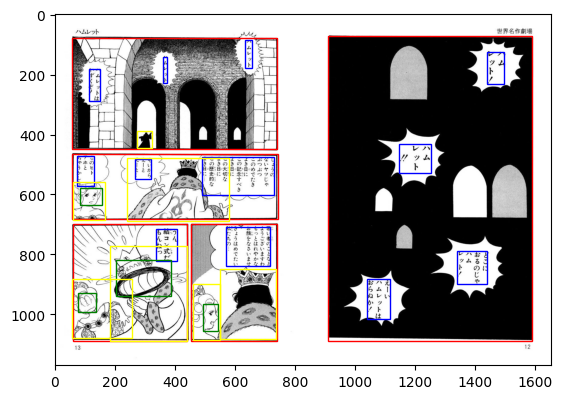

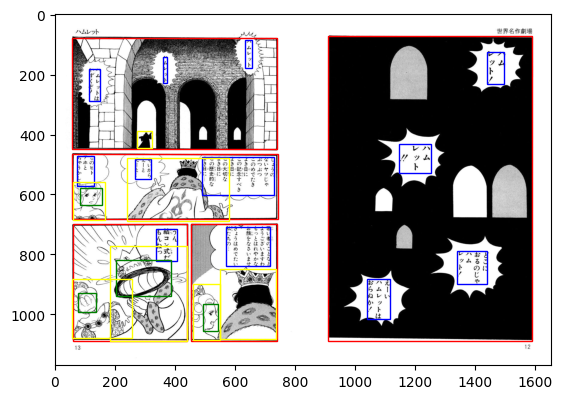

In [6]:
original_image, annotations = dataset.load_manga_page('Hamlet', 6, transformed=False, save_images=True)
transformed_image, annotations = dataset.load_manga_page('Hamlet', 6, transformed=True, save_images=True)